# Augmentations of EEG-signals

In [2]:
import torch
import numpy as np
from datasets.augmentations import *
from datasets.SHHS_dataset_timeonly import SHHS_dataset_1
import matplotlib.pyplot as plt
import os
import scipy.signal as signal
print(os.getcwd())

C:\Users\tomsm\PycharmProjects\thesis02\datasets


In [3]:
# A function for plotting
def plot_augmentation(x, x_aug):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.plot(x.squeeze(), linewidth=1.0, label="Original eeg-signal")
    plt.plot(x_aug.squeeze(), linewidth=1.0, label="Augmented eeg-signal")
    plt.legend(loc="upper left")

## DC-shift

In [4]:
ds = SHHS_dataset_1('../data/', 1, 2)
x = ds.__getitem__(1)[0]
x_prev = ds.__getitem__(0)[0]
p = 1
dc = DCShift(mini=1,
             maxi=5,
             prob=p,
             batch_size=1)
x_dc = dc(x, x_prev)

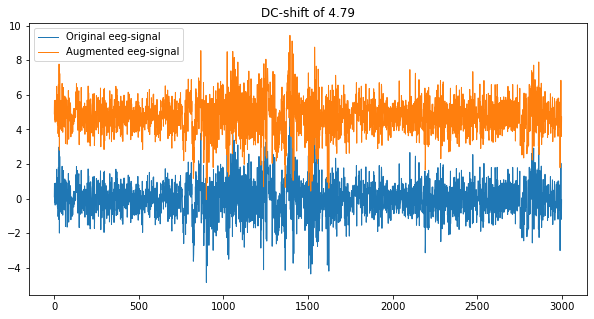

In [5]:
plot_augmentation(x, x_dc)
plt.title(f"DC-shift of {dc.u.item():.2f}")
plt.show()

## Amplitude scale

Text(0.5, 1.0, 'Amplitude shift of 0.70')

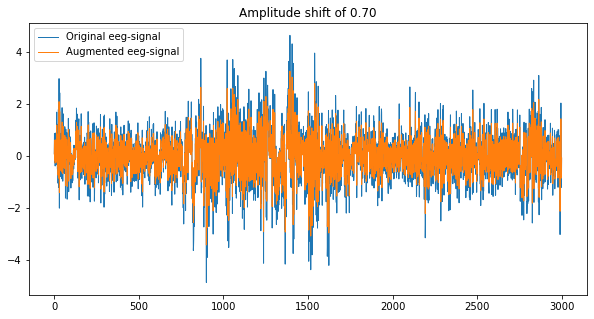

In [6]:
am = AmplitudeScale(mini=0.5,
                    maxi=2,
                    prob=p,
                    batch_size=1)
x_am = am(x, x_prev)
plot_augmentation(x, x_am)
plt.title(f"Amplitude shift of {am.u.item():.2f}")

## Time shift

Text(0.5, 1.0, 'Time shift of 268')

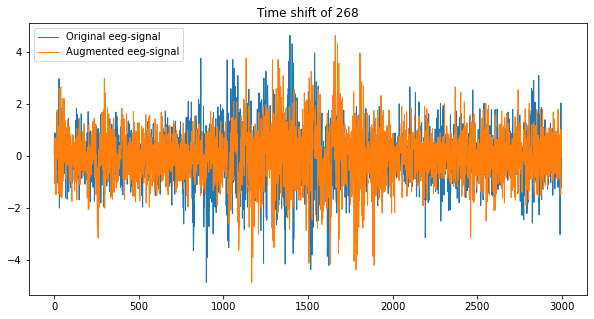

In [7]:
ts = TimeShift(mini=200,
               maxi=400,
               prob=p,
               batch_size=1)
x_ts = ts(x, x_prev)
plot_augmentation(x, x_ts)
plt.title(f"Time shift of {int(ts.u.item())}")

In [7]:
print(x_ts.squeeze()[1])
print(x_prev.squeeze()[-220])

tensor(0.5236)
tensor(0.9840)


## Zero Mask

Text(0.5, 1.0, 'Zero mask of 548')

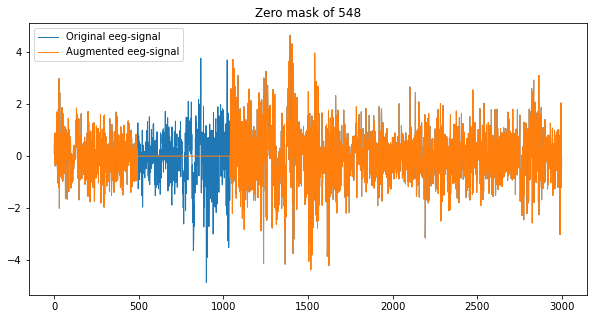

In [8]:
zm = ZeroMask(mini=400,
              maxi=600,
              prob=p,
              batch_size=1)
x_zm = zm(x, x_prev)
plot_augmentation(x, x_zm)
plt.title(f"Zero mask of {int(zm.u.item())}")

## Gaussian noise

Text(0.5, 1.0, 'Additive gaussian noise of stdev: 0.57')

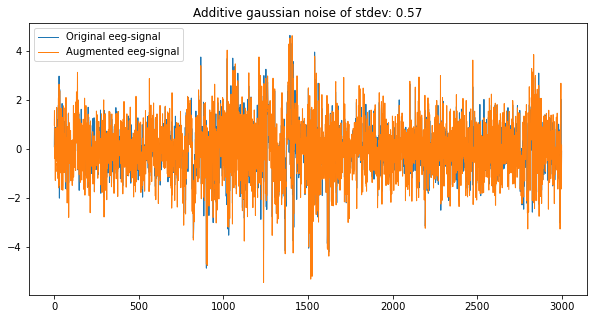

In [9]:
gn = GaussianNoise(mini=0.4,
                   maxi=0.6,
                   prob=p,
                   batch_size=1)
x_gn = gn(x, x_prev)
plot_augmentation(x, x_gn)
plt.title(f"Additive gaussian noise of stdev: {gn.u.item():.2f}")

## Band stop filter: TODO

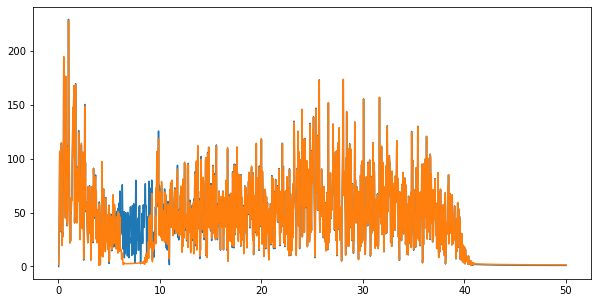

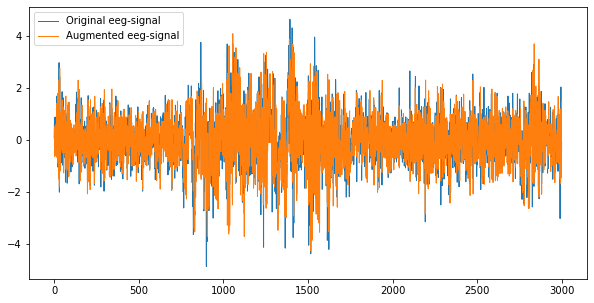

In [10]:

bandstop = BandStopFilter(3, 40, 1, 1, 3)

x_filtered = bandstop(x,x_prev)
N = x.size(2)
x_fft = np.abs(np.fft.fft(x.squeeze()))
freq = np.arange(1, N+1)/N*constants.fs
plt.plot(freq[:int(N/2)], x_fft[:int(N/2)])

x_filtered_fft = np.abs(np.fft.fft(x_filtered.squeeze()))
plt.plot(freq[:int(N/2)], x_filtered_fft[:int(N/2)])
plt.figure()
plot_augmentation(x, x_filtered)

In [26]:
x_filtered = torch.as_tensor(signal.sosfilt(sos, x.squeeze()))
x_filtered = x_filtered[None,None,:]

In [23]:
x_filtered.size()

torch.Size([1, 1, 3000])

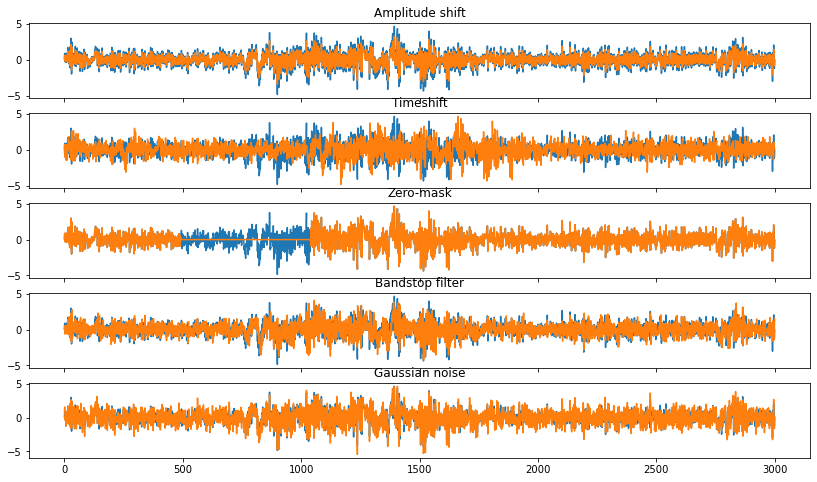

In [25]:
x_augs = [x_am, x_ts, x_zm, x_filtered, x_gn]
aug_names = ['Amplitude shift',
             'Timeshift',
             'Zero-mask',
             'Bandstop filter',
             'Gaussian noise']

fig, axs = plt.subplots(len(x_augs), figsize=(14,8), sharex=True)

for i in range(len(x_augs)):
    axs[i].plot(x.squeeze())
    axs[i].plot(x_augs[i].squeeze())
    axs[i].set_title(aug_names[i])
plt.savefig('augmentations.png', facecolor="white")

## Composition of multiple transforms

Text(0.5, 1.0, 'Two different augmentations of the same signal')

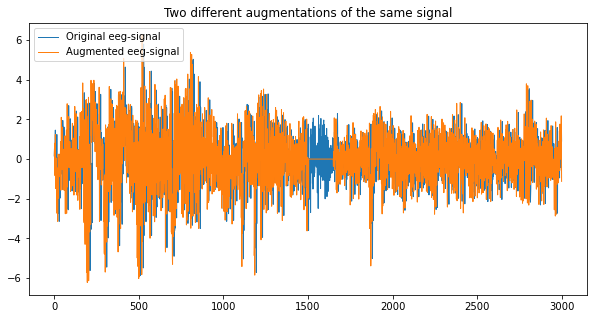

In [34]:
p = 1
contrast_transforms = ContrastiveTransformations(
    [
        AmplitudeScale(0.5, 2, p, 1),
        GaussianNoise(0, 0.2, p, 1),
        ZeroMask(0, 150, p, 1),
        TimeShift(5, 50, p, 1)
    ], n_views=2
)
ds_augmented = SHHS_dataset_1('../../thesis01/data/', 1, 2, transform=contrast_transforms)
x_aug = ds_augmented.__getitem__(0)[0]
plot_augmentation(*x_aug)
plt.title("Two different augmentations of the same signal")

In [11]:
from SHHS_dataset_timeonly import EEGdataModule
dm = EEGdataModule(DATA_PATH='../../thesis01/data/',
                   batch_size=8,
                   data_split=[3, 1],
                   num_patients_train=2,
                   num_patients_test=1,
                   num_workers=0,
                   transform=contrast_transforms)
dm.setup()

In [12]:
train_dataloader = dm.train_dataloader()

In [13]:
batch = next(iter(train_dataloader))
inputs, _ = batch
inputs = torch.cat(inputs, dim=0)


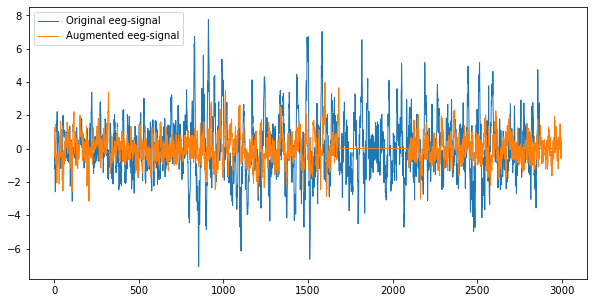

In [14]:
plot_augmentation(inputs[0], inputs[8])